# ANALYSE AND CLASSIFY MUSIC BY LYRICS 
### NLP Final Project
#### Group 3: Danlei Qian, Siqi Jiang, Xi Zhang

In [16]:
import pandas as pd
import os
import bisect
import codecs
import nltk
from aux_bisect import *
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.util import bigrams 
from nltk.tokenize import TreebankWordTokenizer

import warnings
warnings.filterwarnings("ignore")

In [6]:
direct_LEX = 'datasets/lexicons/'

## Import the Corpus Data

In [7]:
training_df = pd.read_csv('train_lyrics_1000.csv')

LS_LYRICS = training_df['lyrics'].values 
mood = training_df['mood'].values

training_df.head()

,file,artist,title,lyrics,genre,mood,year
0,TRAAAAW128F429D538.h5,Casual,I Didn't Mean To,Verse One:\n\nAlright I might\nHave had a litt...,Hip Hop/Rap,sad,1994
1,TRAAAEF128F4273421.h5,Adam Ant,Something Girls,Adam Ant/Marco Pirroni\nEvery girl is a someth...,Rock,happy,1982
2,TRAAAFD128F92F423A.h5,Gob,Face the Ashes,"I've just erased it's been a while, I've got a...",Rock,sad,2007
3,TRAABJV128F1460C49.h5,Lionel Richie,Tonight Will Be Alright,Little darling \nWhere you've been so long \nI...,R&B,happy,1986
4,TRAABLR128F423B7E3.h5,Blue Rodeo,Floating,"Lead Vocal by Greg\n\nWell, these late night c...",Rock,sad,1987


### The First Observation

In [8]:
print(LS_LYRICS[1])

Adam Ant/Marco Pirroni
Every girl is a something girl
Every girl is a something girl
Every girl is a something girl
She's got something
Every girl is a something girl
Every girl has a somehing smile
Every girl is a something girl
For a while
If I had three wishes I know mine
I would not ask the stars to shine
I wouldn't ask for gems or pearls
I'd ask for the something girls
Every girl is a something girl
From the whites of her eyes
To the tip of a curl
Every girl sends a something boy
With that something
When this old world won't treat you right
You're not feeling yourself tonight
Think of someone you can do
Relax and let that something through
Every girl is a something girl
She's got she's got something


## Filter

In [12]:
# import the stopwords
STP = nltk.corpus.stopwords.words('english')
anew0 = pd.read_csv(direct_LEX+'anew.csv')
anew1 = anew0[['Description', 'Valence Mean', 'Arousal Mean']].sort_values(by='Description')
anew2 = anew1['Description'].tolist()
print("Length me: ", len(anew2))

Length me:  1030


In [20]:
with open(direct_LEX+'positive_words_en.txt') as f:
    positive_ = f.read().splitlines()

with open(direct_LEX+'negative_words_en.txt') as f:
    negative_ = f.read().splitlines()
    
positive__neg = sorted(positive_ + negative_)
print("Length: ", len(positive__neg))

MIXCORP = anew2+positive__neg

# Stemmer
PORTERSTEM = PorterStemmer()
MIXCORP = []
for token in MIXCORP:
    MIXCORP.append(PORTERSTEM.stem(token))
MIXCORP = sorted(MIXCORP)
    

Length:  4376


In [30]:
## Process a word
def PROCESSWORD(word, sentiment, lexicon=anew2):
    word = word.lower()
    if not word in STP and word.isalpha():
        if sentiment:
            if find_index(lexicon, word):
                return word
        else:
            return word
    
    return False


def LYRICSTOKENIZER(lyric, sentiment=True):
    ## Pre-procesamos el corpus
    toktok = ToktokTokenizer()

    # Create PTSTEMMER of class PorterStemmer
    PTSTEMMER = PorterStemmer()

    words = toktok.tokenize(lyric)
    WORDSFILTERED = []
    for w in words:
        stemmed = PTSTEMMER.stem(w)
        clean_word = PROCESSWORD(stemmed, sentiment, mixed_corpus)
        if clean_word:
            WORDSFILTERED.append(clean_word)
            
    return WORDSFILTERED


#  Tokenizamos y sacamos las letras con menos de 10 palabras
LYRICSFILTERED = []
for lyric in LS_LYRICS:
    tokenized = LYRICSTOKENIZER(lyric, True)
    if len(tokenized) >= 3:
        LYRICSFILTERED.append(tokenized)
len(LYRICSFILTERED)
#print(LYRICSFILTERED[0:3])

995

## BAG OF WORDS

In [50]:
from gensim import corpora

DICT = corpora.Dictionary(LYRICSFILTERED)
C_BOW = [DICT.doc2bow(lyric) for lyric in LYRICSFILTERED]
print(str(len(C_BOW)))

995


In [10]:
#print(C_BOW)

## Constructing a document-term matrix + LDA

In [37]:
from gensim.models.ldamulticore import LdaMulticore

def LDA_MODEL(corpus, num_topics, passes):
    lda_model = LdaMulticore(
        corpus, 
        num_topics=num_topics, 
        id2word = DICT, 
        passes = passes,
        workers = 3,
        minimum_probability=0.001
    )        
    return lda_model


In [38]:
def LDA_PRINTER(lda_model, num_words=8):
    prin = lda_model.print_topics(num_topics=num_topics, num_words=num_words)
    for i in prin:
        print(i)

In [46]:
## Process a word
def PROCESSWORD2(word, sentiment, lexicon=anew2):
    word = word.lower()
    if word.isalpha():
        if sentiment:
            if find_index(lexicon, word):
                return word
        else:
            return word
    
    return False


def LYRICSTOKENIZER2(lyric, sentiment=True):
    toktok = ToktokTokenizer()

    PORTERSTEM = PorterStemmer()

    words = toktok.tokenize(lyric)
    WORDSFINDER = []
    for w in words:
        stemmed = PORTERSTEM.stem(w)
        clean_word = PROCESSWORD2(stemmed, sentiment, MIXCORP)
        if clean_word:
            WORDSFINDER.append(clean_word)
            
    return WORDSFINDER


tokenized_lyrics = []
for lyric in LS_LYRICS:
    tokenized = LYRICSTOKENIZER2(lyric, False)
    if len(tokenized) >= 0:
        tokenized_lyrics.append(tokenized)
len(tokenized_lyrics)


def CONTEXT_CATCHER(word, corpus):
    CONTEXT_CORPUS = []
    for lyric in corpus:
        CONTEXT_LYRICS = []
        for i in range(len(lyric)):
            if word == lyric[i]:
                CONTEXT_WORD = []
                try:
                    CONTEXT_WORD.append(lyric[i-3])
                    CONTEXT_WORD.append(lyric[i-2])
                    CONTEXT_WORD.append(lyric[i-1])
                    CONTEXT_WORD.append(lyric[i])
                    CONTEXT_WORD.append(lyric[i+1])
                    CONTEXT_WORD.append(lyric[i+2])
                    CONTEXT_WORD.append(lyric[i+3])
                    if not CONTEXT_WORD in CONTEXT_LYRICS:
                        CONTEXT_LYRICS.append(CONTEXT_WORD)
                except:
                    pass
        if CONTEXT_LYRICS:
            CONTEXT_CORPUS.append(CONTEXT_LYRICS)
    return CONTEXT_CORPUS


In [53]:
num_topics = 6
lda_model = LDA_MODEL(C_BOW, num_topics, 200)
LDA_PRINTER(lda_model)

(0, '0.052*"time" + 0.027*"life" + 0.026*"live" + 0.018*"heart" + 0.018*"fall" + 0.017*"world" + 0.016*"free" + 0.016*"right"')
(1, '0.072*"babi" + 0.036*"well" + 0.025*"cri" + 0.024*"home" + 0.022*"lose" + 0.020*"pleas" + 0.019*"hot" + 0.018*"time"')
(2, '0.226*"love" + 0.040*"babi" + 0.040*"girl" + 0.023*"rain" + 0.022*"heart" + 0.021*"lone" + 0.020*"time" + 0.018*"like"')
(3, '0.102*"like" + 0.021*"play" + 0.019*"shit" + 0.018*"fuck" + 0.018*"song" + 0.017*"better" + 0.013*"time" + 0.010*"gun"')
(4, '0.044*"man" + 0.025*"like" + 0.024*"right" + 0.021*"mind" + 0.018*"hit" + 0.017*"boy" + 0.016*"rock" + 0.016*"girl"')
(5, '0.027*"world" + 0.023*"hand" + 0.020*"believ" + 0.020*"time" + 0.016*"lie" + 0.014*"long" + 0.014*"life" + 0.014*"dream"')
CPU times: user 2min 47s, sys: 11.2 s, total: 2min 58s
Wall time: 2min 59s


In [57]:
#pip install pyLDAvis
import pyLDAvis.gensim
    
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, C_BOW, DICT)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.027820 -0.161202       1        1  22.148561
3     -0.160720  0.032317       2        1  20.648182
2      0.204506  0.092397       3        1  17.141678
5      0.024179 -0.143315       4        1  14.026779
4     -0.165440  0.077739       5        1  13.849354
1      0.069655  0.102063       6        1  12.185447, topic_info=      Term         Freq        Total Category  logprob  loglift
79    love  1499.000000  1499.000000  Default  30.0000  30.0000
68    babi   612.000000   612.000000  Default  29.0000  29.0000
25    like  1223.000000  1223.000000  Default  28.0000  28.0000
186    man   403.000000   403.000000  Default  27.0000  27.0000
19    girl   413.000000   413.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
19    girl    48.209690   413.472656   Topic6  -4.5476  -0.0441
25    like    63.541878  1223.138916   Topic6  -4.2715  -0.8525
78    long    40.854271   291.918427   Topic6  -4.7132   0.1385
81    play    33.640720   241.159790   Topic6  -4.9074   0.1352
75   heart    34.907719   422.558197   Topic6  -4.8705  -0.3887

[434 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1758      6  0.907200     ace
1029      5  0.936446  achiev
1503      3  0.841632   adapt
1468      3  0.075602   admir
1468      6  0.831621   admir
...     ...       ...     ...
140       3  0.385250   wrong
140       4  0.305754   wrong
140       5  0.024460   wrong
1034      4  0.963555  yellow
926       5  0.952915   zombi

[858 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 6, 5, 2])

In [58]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in LYRICSFILTERED for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.8); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.savefig("out.png")

In [60]:
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.COHEN_MOD import COHEN_MOD
import matplotlib.pyplot as plt
from gensim.models.ldamulticore import LdaMulticore


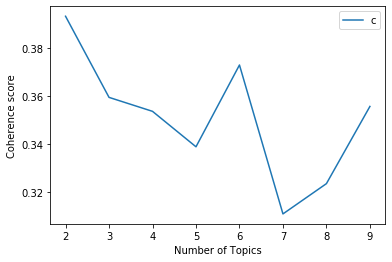

In [66]:
def COPUS_PRE(doc_clean):

    DICT = corpora.Dictionary(doc_clean)

    MATRIX_TERMS = [DICT.doc2bow(doc) for doc in doc_clean]

    return DICT,MATRIX_TERMS

def create_gensim_lsa_model(doc_clean,TOPICNUMBERS,words):

    DICT,MATRIX_TERMS=COPUS_PRE(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(MATRIX_TERMS, num_topics=TOPICNUMBERS, id2word = DICT)  # train model
    print(lsamodel.print_topics(num_topics=TOPICNUMBERS, num_words=words))
    return lsamodel

def COHERENCE_COMPUTER(DICT, MATRIX_TERMS, doc_clean, stop, start=2, step=3):

    VALUE_COH = []
    LST_MODEL = []
    for TOPICNUMBERS in range(start, stop, step):
        model = LDA_MODEL(MATRIX_TERMS, TOPICNUMBERS, 5)

        LST_MODEL.append(model)
        COHEN_MOD = COHEN_MOD(model=model, texts=doc_clean, dictionary=DICT, coherence='c_v')
        VALUE_COH.append(COHEN_MOD.get_coherence())
    return LST_MODEL, VALUE_COH

def PLOTGRAPHER(doc_clean,start, stop, step):
    DICT,MATRIX_TERMS=COPUS_PRE(doc_clean)
    LST_MODEL, VALUE_COH = COHERENCE_COMPUTER(DICT, MATRIX_TERMS,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, VALUE_COH)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("VALUE_COH"), loc='best')
    plt.show()
    
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.COHEN_MOD import COHEN_MOD
import matplotlib.pyplot as plt
from gensim.models.ldamulticore import LdaMulticore
start,stop,step=2,10,1
PLOTGRAPHER(LYRICSFILTERED,start,stop,step)

## LSA

In [67]:
from gensim.models import LsiModel

num_topics = 6
lsi = LsiModel(C_BOW, id2word=DICT, num_topics=num_topics)
lsi.print_topics(num_topics=num_topics, num_words=8)


[(0,
  '0.835*"love" + 0.294*"like" + 0.239*"babi" + 0.185*"time" + 0.110*"girl" + 0.081*"man" + 0.078*"heart" + 0.072*"right"'),
 (1,
  '-0.672*"like" + 0.482*"love" + -0.220*"time" + -0.139*"girl" + -0.131*"right" + -0.122*"hit" + -0.120*"man" + -0.110*"shit"'),
 (2,
  '-0.488*"girl" + -0.482*"lone" + 0.416*"like" + -0.391*"babi" + -0.284*"time" + 0.159*"love" + 0.087*"hit" + -0.085*"good"'),
 (3,
  '-0.709*"time" + 0.372*"lone" + 0.327*"girl" + 0.287*"like" + -0.167*"play" + 0.113*"babi" + -0.110*"celebr" + -0.104*"song"'),
 (4,
  '0.772*"play" + 0.428*"song" + 0.231*"long" + -0.229*"babi" + 0.199*"lone" + -0.187*"time" + 0.078*"music" + 0.077*"pleas"'),
 (5,
  '0.702*"babi" + -0.336*"lone" + 0.257*"hot" + -0.256*"world" + 0.235*"play" + -0.180*"girl" + -0.169*"money" + 0.125*"fight"')]

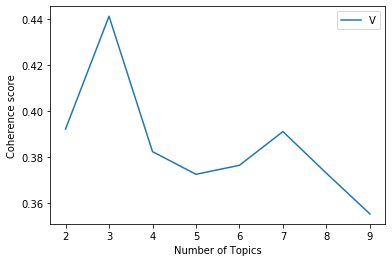

In [78]:
def COPUS_PRE(doc_clean):

    DICT = corpora.Dictionary(doc_clean)
    MATRIX_TERMS = [DICT.doc2bow(doc) for doc in doc_clean]

    return DICT,MATRIX_TERMS


def COHERENCE_COMPUTER(DICT, MATRIX_TERMS, doc_clean, stop, start=2, step=3):

    VALUE_COH = []
    LST_MODEL = []
    for TOPICNUMBERS in range(start, stop, step):
        model = LsiModel(MATRIX_TERMS, num_topics=TOPICNUMBERS, id2word = DICT)
        LST_MODEL.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=DICT, coherence='c_v')
        VALUE_COH.append(coherencemodel.get_coherence())
    return LST_MODEL, VALUE_COH

def PLOTGRAPHER(doc_clean,start, stop, step):
    DICT,MATRIX_TERMS=COPUS_PRE(doc_clean)
    LST_MODEL, VALUE_COH = COHERENCE_COMPUTER(DICT, MATRIX_TERMS,doc_clean,
                                                            stop, start, step)
    x = range(start, stop, step)
    plt.plot(x, VALUE_COH)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("VALUE_COH"), loc='best')
    plt.show()
    

start,stop,step=2,10,1

PLOTGRAPHER(LYRICSFILTERED,start,stop,step)

## HDP

In [71]:
from gensim.models import HdpModel

hdp = HdpModel(C_BOW, id2word=DICT)
hdp.print_topics(num_topics=6, num_words=8)

/Users/Fox/opt/anaconda3/lib/python3.7/site-packages/gensim/models/hdpmodel.py:467: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  start_time = time.clock()


[(0,
  '0.013*like + 0.011*love + 0.008*time + 0.007*lone + 0.007*life + 0.005*man + 0.005*live + 0.005*right'),
 (1,
  '0.005*love + 0.004*like + 0.004*fall + 0.004*babi + 0.003*fight + 0.003*peculiar + 0.003*cook + 0.003*time'),
 (2,
  '0.020*love + 0.006*time + 0.006*cri + 0.006*babi + 0.005*rain + 0.005*like + 0.004*wasp + 0.004*chanc'),
 (3,
  '0.006*like + 0.004*love + 0.004*live + 0.004*time + 0.004*scare + 0.003*object + 0.003*welcom + 0.003*fuck'),
 (4,
  '0.006*like + 0.004*girl + 0.004*unwelcom + 0.003*boy + 0.003*crown + 0.003*tomb + 0.003*faster + 0.003*loyalti'),
 (5,
  '0.006*love + 0.006*like + 0.005*mind + 0.004*time + 0.004*aliv + 0.003*hard + 0.003*invis + 0.003*doctor')]

/Users/Fox/opt/anaconda3/lib/python3.7/site-packages/gensim/models/hdpmodel.py:467: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  start_time = time.clock()
/Users/Fox/opt/anaconda3/lib/python3.7/site-packages/gensim/models/hdpmodel.py:467: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  start_time = time.clock()
/Users/Fox/opt/anaconda3/lib/python3.7/site-packages/gensim/models/hdpmodel.py:467: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  start_time = time.clock()
/Users/Fox/opt/anaconda3/lib/python3.7/site-packages/gensim/models/hdpmodel.py:467: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_count

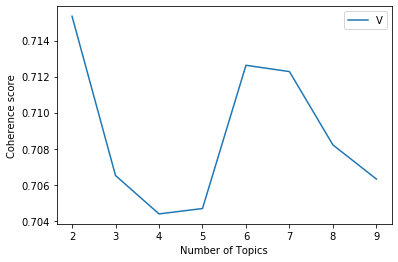

In [80]:
def COPUS_PRE(doc_clean):

    DICT = corpora.Dictionary(doc_clean)

    MATRIX_TERMS = [DICT.doc2bow(doc) for doc in doc_clean]

    return DICT,MATRIX_TERMS

def COHERENCE_COMPUTER(DICT, MATRIX_TERMS, doc_clean, stop, start=2, step=3):

    VALUE_COH = []
    LST_MODEL = []
    for TOPICNUMBERS in range(start, stop, step):
        model= HdpModel(MATRIX_TERMS, id2word=DICT)
        LST_MODEL.append(model)
        COHEN_MOD = CoherenceModel(model=model, texts=doc_clean, dictionary=DICT, coherence='c_v')
        VALUE_COH.append(COHEN_MOD.get_coherence())
    return LST_MODEL, VALUE_COH

def PLOTGRAPHER(doc_clean,start, stop, step):
    DICT,MATRIX_TERMS=COPUS_PRE(doc_clean)
    LST_MODEL, VALUE_COH = COHERENCE_COMPUTER(DICT, MATRIX_TERMS,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, VALUE_COH)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("VALUE_COH"), loc='best')
    plt.show()

start,stop,step=2,10,1

PLOTGRAPHER(LYRICSFILTERED,start,stop,step)

## Cluster

In [87]:
word = 'life'
print(lda_model.get_term_topics(PORTERSTEM.stem(word)))

res = CONTEXT_CATCHER(word, tokenized_lyrics)
res[:3]

[(0, 0.027289324), (1, 0.0022600808), (2, 0.009434069), (4, 0.0090786405), (5, 0.013915073)]


[[['you', 'tell', 'me', 'life', 'is', 'for', 'live']],
 [['it', 's', 'my', 'life', 'to', 'live', 'my']],
 [['is', 'just', 'your', 'life', 'brain', 'of', 'the'],
  ['brain', 'of', 'the', 'life', 'your', 'singl', 'one'],
  ['one', 'and', 'onli', 'life', 'i', 'm', 'start'],
  ['is', 'just', 'your', 'life', 'choru', 'thi', 'is'],
  ['is', 'just', 'your', 'life', 'i', 'm', 'say']]]

## Collect Lyrics and Classify by LDA, LSA and HDP

In [103]:
from PyLyrics import *
westlife_love = PyLyrics.getLyrics("Westlife","My Love")

charlie_sad = PyLyrics.getLyrics("Charlie Puth","We don't talk anymore")

Lana_depressing = PyLyrics.getLyrics("Lana Del Rey","The Blackest Day")

eminem_violence =  PyLyrics.getLyrics("Eminem","One Shot 2 Shot")

love_happy = PyLyrics.getLyrics("Pharrell Williams","Happy")

In [104]:
# LOVE
TOKENIZOR__ = LYRICSTOKENIZER(westlife_love)
VECTORS_ = DICT.doc2bow(TOKENIZOR__)
LST_TOPIC = lda_model[VECTORS_]
print("LOVE")
print("Sentiment Words")
print(set(TOKENIZOR__))
print(LST_TOPIC)
print

# SAD
TOKENIZOR__ = LYRICSTOKENIZER(charlie_sad)
VECTORS_ = DICT.doc2bow(TOKENIZOR__)
LST_TOPIC = lda_model[VECTORS_]
print("LOVE SAD")
print("Sentiment Words")
print(set(TOKENIZOR__))
print(LST_TOPIC)
print

# Depressing
TOKENIZOR__ = LYRICSTOKENIZER(Lana_depressing)
VECTORS_ = DICT.doc2bow(TOKENIZOR__)
LST_TOPIC = lda_model[VECTORS_]
print("DEPRESSING")
print("Sentiment Words")
print(set(TOKENIZOR__))
print(LST_TOPIC)
print

# Violence
TOKENIZOR__ = LYRICSTOKENIZER(eminem_violence)
VECTORS_ = DICT.doc2bow(TOKENIZOR__)
LST_TOPIC = lda_model[VECTORS_]
print("ANGER")
print("Sentiment Words")
print(set(TOKENIZOR__))
print(LST_TOPIC)
print


# Happy
TOKENIZOR__ = LYRICSTOKENIZER(love_happy)
VECTORS_ = DICT.doc2bow(TOKENIZOR__)
LST_TOPIC = lda_model[VECTORS_]
print("HAPPY")
print("Sentiment Words")
print(set(TOKENIZOR__))
print(LST_TOPIC)
print

LOVE
Sentiment Words
{'arm', 'alon', 'field', 'love', 'wonder', 'work', 'hous', 'coast', 'sky', 'friend', 'promis', 'hope', 'street', 'empti', 'song', 'green', 'blue', 'heart', 'dream'}
[(0, 0.27785775), (1, 0.0024687294), (2, 0.39472473), (3, 0.1476933), (4, 0.17478377), (5, 0.002471701)]
LOVE SAD
Sentiment Words
{'wonder', 'like', 'time', 'afraid', 'kind', 'lie', 'reason', 'door', 'hope', 'right', 'wrong', 'good', 'game', 'love', 'shame', 'dress', 'use'}
[(0, 0.18737075), (1, 0.0031843442), (2, 0.3131264), (3, 0.4899795), (4, 0.003176817), (5, 0.0031621903)]
DEPRESSING
Sentiment Words
{'holiday', 'wrong', 'fall', 'phase', 'love', 'easi', 'favorit', 'break', 'god', 'home', 'polish', 'hard', 'better', 'air', 'hand', 'darker', 'song', 'color', 'game', 'blue', 'gun', 'like', 'play', 'car', 'lost', 'radio', 'babi', 'dream'}
[(0, 0.22543088), (1, 0.09719203), (2, 0.28048152), (3, 0.39087301), (4, 0.0030064725), (5, 0.0030160898)]
ANGER
Sentiment Words
{'dumb', 'clear', 'bullet', 'mess', 'f

<function print>

In [105]:
#LSA
# Love
TOKENIZOR__ = LYRICSTOKENIZER(westlife_love)
VECTORS_ = DICT.doc2bow(TOKENIZOR__)
LST_TOPIC = lsi[VECTORS_]
print("Love")
print("Sentiment Words")
print(set(TOKENIZOR__))
print(LST_TOPIC)
print

# sad
TOKENIZOR__ = LYRICSTOKENIZER(charlie_sad)
VECTORS_ = DICT.doc2bow(TOKENIZOR__)
LST_TOPIC = lsi[VECTORS_]
print("Love Sad")
print("Sentiment Words")
print(set(TOKENIZOR__))
print(LST_TOPIC)
print

# Depressing
TOKENIZOR__ = LYRICSTOKENIZER(Lana_depressing)
VECTORS_ = DICT.doc2bow(TOKENIZOR__)
LST_TOPIC = lsi[VECTORS_]
print("Depressing, sad")
print("Sentiment Words")
print(set(TOKENIZOR__))
print(LST_TOPIC)
print

# Anger
TOKENIZOR__ = LYRICSTOKENIZER(eminem_violence)
VECTORS_ = DICT.doc2bow(TOKENIZOR__)
LST_TOPIC = lsi[VECTORS_]
print("Anger")
print("Sentiment Words")
print(set(TOKENIZOR__))
print(LST_TOPIC)
print


# Happy
TOKENIZOR__ = LYRICSTOKENIZER(love_happy)
VECTORS_ = DICT.doc2bow(TOKENIZOR__)
LST_TOPIC = lsi[VECTORS_]
print("Love Happy")
print("Sentiment Words")
print(set(TOKENIZOR__))
print(LST_TOPIC)
print

Love
Sentiment Words
{'arm', 'alon', 'field', 'love', 'wonder', 'work', 'hous', 'coast', 'sky', 'friend', 'promis', 'hope', 'street', 'empti', 'song', 'green', 'blue', 'heart', 'dream'}
[(0, 15.11623349656738), (1, 7.259218782637174), (2, 2.559813128871195), (3, 0.16833226216346245), (4, 1.7660262784796599), (5, -2.1909736442690835)]
Love Sad
Sentiment Words
{'wonder', 'like', 'time', 'afraid', 'kind', 'lie', 'reason', 'door', 'hope', 'right', 'wrong', 'good', 'game', 'love', 'shame', 'dress', 'use'}
[(0, 11.391781900773715), (1, -3.650943437820845), (2, 5.188129091638683), (3, 2.1523886010461086), (4, -0.26756768191527414), (5, -0.8943347457026494)]
Depressing, sad
Sentiment Words
{'holiday', 'wrong', 'fall', 'phase', 'love', 'easi', 'favorit', 'break', 'god', 'home', 'polish', 'hard', 'better', 'air', 'hand', 'darker', 'song', 'color', 'game', 'blue', 'gun', 'like', 'play', 'car', 'lost', 'radio', 'babi', 'dream'}
[(0, 3.8560895949661136), (1, -1.4572436632516843), (2, -1.13852382173

<function print>

In [106]:
#HDP
# Love
TOKENIZOR__ = LYRICSTOKENIZER(westlife_love)
VECTORS_ = DICT.doc2bow(TOKENIZOR__)
LST_TOPIC = hdp[VECTORS_]
print("Love")
print("Sentiment Words")
print(set(TOKENIZOR__))
print(LST_TOPIC)
print

# sad
TOKENIZOR__ = LYRICSTOKENIZER(charlie_sad)
VECTORS_ = DICT.doc2bow(TOKENIZOR__)
LST_TOPIC = hdp[VECTORS_]
print("Love Sad")
print("Sentiment Words")
print(set(TOKENIZOR__))
print(LST_TOPIC)
print

# Depressing
TOKENIZOR__ = LYRICSTOKENIZER(Lana_depressing)
VECTORS_ = DICT.doc2bow(TOKENIZOR__)
LST_TOPIC = hdp[VECTORS_]
print("Depressing")
print("Sentiment Words")
print(set(TOKENIZOR__))
print(LST_TOPIC)
print

# Anger
TOKENIZOR__ = LYRICSTOKENIZER(eminem_violence)
VECTORS_ = DICT.doc2bow(TOKENIZOR__)
LST_TOPIC = hdp[VECTORS_]
print("Anger")
print("Sentiment Words")
print(set(TOKENIZOR__))
print(LST_TOPIC)
print


# Happy
TOKENIZOR__ = LYRICSTOKENIZER(love_happy)
VECTORS_ = DICT.doc2bow(TOKENIZOR__)
LST_TOPIC = hdp[VECTORS_]
print("Happy")
print("Sentiment Words")
print(set(TOKENIZOR__))
print(LST_TOPIC)
print

Love
Sentiment Words
{'arm', 'alon', 'field', 'love', 'wonder', 'work', 'hous', 'coast', 'sky', 'friend', 'promis', 'hope', 'street', 'empti', 'song', 'green', 'blue', 'heart', 'dream'}
[(0, 0.986499560921661)]
Love Sad
Sentiment Words
{'wonder', 'like', 'time', 'afraid', 'kind', 'lie', 'reason', 'door', 'hope', 'right', 'wrong', 'good', 'game', 'love', 'shame', 'dress', 'use'}
[(0, 0.9826786819372386)]
Depressing
Sentiment Words
{'holiday', 'wrong', 'fall', 'phase', 'love', 'easi', 'favorit', 'break', 'god', 'home', 'polish', 'hard', 'better', 'air', 'hand', 'darker', 'song', 'color', 'game', 'blue', 'gun', 'like', 'play', 'car', 'lost', 'radio', 'babi', 'dream'}
[(0, 0.832464277638526), (123, 0.15122028235759644)]
Anger
Sentiment Words
{'dumb', 'clear', 'bullet', 'mess', 'fun', 'human', 'trap', 'bizarr', 'fuck', 'face', 'collaps', 'bar', 'wild', 'black', 'odd', 'fan', 'fire', 'strut', 'desert', 'bitch', 'hug', 'carcass', 'secur', 'music', 'god', 'hit', 'hous', 'outsid', 'saint', 'bod

<function print>